# Mount drive

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [21]:
%tensorflow_version 1.x
!pip3 install tensorflow==1.15.2
!pip3 install biopython
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from Bio import SeqIO
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from warnings import simplefilter
import os
import pickle
import random

simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# import sys
# np.set_printoptions(threshold=sys.maxsize)

In [22]:
print(tf.__version__)

1.15.2


# Functions

In [23]:
def fasta_frame(fasta_file,label):
  identifiers = []
  sequences = []
  with open(fasta_file) as f_f:
    for seq_record in SeqIO.parse(f_f, 'fasta'):
        identifiers.append(seq_record.id)
        sequences.append(seq_record.seq.lower())
  s1 = pd.Series(identifiers, name='ID')
  s2 = pd.Series(sequences, name='sequence')
  fasta_frame = pd.DataFrame(dict(ID=s1, sequence=s2))
  fasta_frame['label']=label
  return(fasta_frame)

def ohe_fun(coluna):
  integer_encoder = LabelEncoder()  
  one_hot_encoder = OneHotEncoder(categories='auto')   
  input_features = []

  for linha in coluna[coluna.columns[1]]:
    integer_encoded = integer_encoder.fit_transform(list(linha))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())
  input_features=pad_sequences(input_features, padding='post')
  input_features = np.stack(input_features)
  return(input_features)

def flatten_sequence(pred_fasta_flat):
  dimensoes=pred_fasta_flat.shape
  n_samples=dimensoes[0]
  n_x=dimensoes[1]
  n_y=dimensoes[2]
  n_xy=(n_x * n_y)
  pred_fasta_flat=pred_fasta_flat.reshape(n_samples,n_xy)
  return(pred_fasta_flat)

# Seeds

In [24]:
SEED = 13
tf.compat.v1.random.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Preprocessing

In [ ]:
te_frame = fasta_frame('/content/drive/My Drive/fastas/db_te_new_training_dataset.fasta','TE')
rd_frame = fasta_frame('/content/drive/My Drive/fastas/tds00_danio_rerio_ncrna.fasta','NT')
s_f = [rd_frame,te_frame]
seq_df = pd.concat(s_f,ignore_index=True)
pd.set_option('display.max_rows', len(seq_df))
seq_df.sample(10)

,ID,sequence,label
14181,GYPSY-28_DAN-I_GYPSY_DROSOPHILA_ANANASSAE,"(a, a, a, t, t, t, t, t, t, t, t, t, t, t, a, ...",TE
14182,HAT-N14C_OS_HAT_ORYZA_SATIVA,"(t, a, g, g, g, c, t, g, t, c, a, a, a, a, a, ...",TE
14183,MARINER-5_DAN_MARINER/TC1_DROSOPHILA_ANANASSAE,"(c, a, c, t, c, a, t, g, g, a, c, a, a, a, a, ...",TE
14184,GYPSY-27_DP-I_GYPSY_DROSOPHILA_PERSIMILIS,"(a, c, t, t, c, a, g, a, a, g, t, g, g, g, a, ...",TE
14185,BAJIELTR_LTR_RETROTRANSPOSON_ORYZA_SATIVA,"(t, g, t, t, a, g, g, g, t, t, a, t, g, g, a, ...",TE


**Save data frame to file**

In [ ]:
#seq_df.to_csv('/content/drive/My Drive/ml_df_train_set_Nadd.csv', index = False)

**Load saved data frame**

In [ ]:
seq_df = pd.read_csv('/content/drive/My Drive/ml_df_train_set_00.01.csv')

In [ ]:
seq_df = pd.read_csv('/content/drive/My Drive/nadd_ml_df_train_set_00.01.csv')

In [ ]:
seq_df = pd.read_csv('/content/drive/My Drive/tds_nadd_02.01.csv')

In [ ]:
seq_df = pd.read_csv('/content/drive/My Drive/tds_feats_nadd_02.01.csv')

In [25]:
seq_df = pd.read_csv('/content/drive/My Drive/db_te_classified_beta.csv')

In [26]:
seq_df

,id,class,order,family,score,species,sequence,length
0,5S,Retro,SINE,5S,844,Homo sapiens,GTCTACTGCCATACCACCCTGAACACGCCCGATCTCATCTGATCTT...,120
1,5S-Sauria,Retro,SINE,5S,3230,Anolis carolinensis,GCCTACGGCCATACCACCCTGAACACGCCCGATCTCGTCTGATCTC...,348
2,5S_CPo,Retro,SINE,5S,1017,Cavia porcellus,GTCTACGGCCATACCACCCTGAACGCGCCCGATCTCGTCTGATCTC...,138
3,AACOPIA1_I,Retro,LTR,Copia,38433,Aedes aegypti,GGTGATGGGCCCAGCGCAAGGCCCCCGCGGGATTTGTGAAAGTGAA...,4110
4,AACOPIA1_LTR,Retro,LTR,Copia,2518,Aedes aegypti,TGTGGAGAATGCATCGGTGTACCCCTTCACTACTGCACGAATACCC...,270
...,...,...,...,...,...,...,...,...
47249,rn_364-201_LTR,Retro,LTR,Gypsy,10061,Oryza sativa,TGTAACAGCCCTAGGTTCATAACCAGGTATTTAGAAGTGCTTTTGT...,3868
47250,rn_364-201_LTR,Retro,LTR,Gypsy,10061,Oryza sativa,TGTAACAGCCCTAGGTTCATAACCAGGTATTTAGAAGTGTATTTGT...,1138
47251,tRNA-Lys-AAG,Retro,LTR,Gypsy,685,Vertebrata,GCCCGGCTAGCTCAGTCGGTAGAGCATGAGACTCTTAATCTCAGGG...,76
47252,tSINE_Fc,Retro,SINE,tRNA,988,Felis catus,GGGGCGCCTGGCTGGCTCAGTCGGTAGAGCATGCGACTCTTGATCT...,110


In [ ]:
seq_df['multi']=seq_df['label'].map(str)+';'+seq_df['class'].map(str)+';'+seq_df['family'].map(str)
seq_df

In [27]:
seq_df.shape

(47254, 8)

In [ ]:
seq_df = seq_df.loc[~seq_df['id'].str.contains('ENSDART')]
seq_df

In [ ]:
seq_df.loc[seq_df['class']=='DNA']['family'].value_counts()

In [28]:
seq_df['class'].value_counts()

Retro    33883
DNA      13371
Name: class, dtype: int64

In [30]:
seq_df['order'].value_counts()

LTR         25655
TIR         11946
LINE         6588
dnaSC2       1164
SINE          714
Penelope      509
DIRS          417
Crypton       261
Name: order, dtype: int64

In [29]:
seq_df['family'].value_counts()

Gypsy       11663
Copia        7099
hAT          3456
TcMar        2855
ERV1         2485
            ...  
Deceiver        4
Genie           3
TRIM            2
R4              2
Ceph            2
Name: family, Length: 64, dtype: int64

In [ ]:
seq_df['multi'].unique()

**Transform sequences and labels**

In [ ]:
x_sequence_arrays = ohe_fun(seq_df)
x_flat_2d = flatten_sequence(x_sequence_arrays)
y_str = seq_df['label']

**Word embedding**

In [31]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=None,split=' ', char_level=True, lower=True)
sequencias = seq_df['sequence']
tokenizer.fit_on_texts(sequencias)

print(tokenizer.word_counts)
print(tokenizer.document_count)
print(tokenizer.word_index)
print(tokenizer.word_docs)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
x_sequence_arrays = tokenizer.texts_to_sequences(sequencias)

OrderedDict([('g', 30503915), ('t', 36630158), ('c', 29570600), ('a', 40635369), ('n', 201517), ('x', 27717)])
47254
{'a': 1, 't': 2, 'g': 3, 'c': 4, 'n': 5, 'x': 6}
defaultdict(<class 'int'>, {'g': 47254, 'c': 47254, 'a': 47254, 't': 47254, 'n': 15722, 'x': 163})
7


In [32]:
print(sequencias[2])
print(x_sequence_arrays[2])

GTCTACGGCCATACCACCCTGAACGCGCCCGATCTCGTCTGATCTCGGAAGCTAAGCAGGGTCGGGCCTGGTTAGTACTTGGATGGGAGACCGCCTGGGAATACCGGGTGCTGTAGGCTTTAAAAAAAAAAAAAAAAA
[3, 2, 4, 2, 1, 4, 3, 3, 4, 4, 1, 2, 1, 4, 4, 1, 4, 4, 4, 2, 3, 1, 1, 4, 3, 4, 3, 4, 4, 4, 3, 1, 2, 4, 2, 4, 3, 2, 4, 2, 3, 1, 2, 4, 2, 4, 3, 3, 1, 1, 3, 4, 2, 1, 1, 3, 4, 1, 3, 3, 3, 2, 4, 3, 3, 3, 4, 4, 2, 3, 3, 2, 2, 1, 3, 2, 1, 4, 2, 2, 3, 3, 1, 2, 3, 3, 3, 1, 3, 1, 4, 4, 3, 4, 4, 2, 3, 3, 3, 1, 1, 2, 1, 4, 4, 3, 3, 3, 2, 3, 4, 2, 3, 2, 1, 3, 3, 4, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [33]:
# integer encode documents
encoded_docs = tokenizer.texts_to_matrix(sequencias, mode='count')
print(encoded_docs)

[[ 0. 25. 27. ... 31.  0.  0.]
 [ 0. 83. 71. ... 96.  0.  0.]
 [ 0. 39. 27. ... 33.  0.  0.]
 ...
 [ 0. 13. 16. ... 22.  0.  0.]
 [ 0. 27. 29. ... 21.  0.  0.]
 [ 0. 54. 45. ... 36.  0.  0.]]


In [34]:
from keras.preprocessing.sequence import pad_sequences
padded_seqs = pad_sequences(x_sequence_arrays, padding='post')
padded_seqs[2,:]

array([3, 2, 4, ..., 0, 0, 0], dtype=int32)

In [ ]:
y_str = seq_df['order']
y_str

0       DNA
1       LTR
2       LTR
3       LTR
4       LTR
       ... 
7533    LTR
7534    LTR
7535    LTR
7536    LTR
7537    LTR
Name: class, Length: 7538, dtype: object

### Find dataframe's longest sequence

In [ ]:
ll_index = seq_df.sequence.map(len).idxmax()
longest_len = seq_df.sequence.map(len).max()
longest_len_id = seq_df.iloc[ll_index]
longest_len_id = list(longest_len_id)[0]
# Print result
print(f"Index: {ll_index}, ID: {longest_len_id}, Length: {longest_len}")

Index: 7809, ID: Helitron-2_DR	Helitron	Danio rerio seq1, Length: 27418


# Baseline algorithm

In [ ]:
# Set baseline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

x_train, x_test, y_train, y_test = train_test_split(padded_seqs, 
                                                    y_str,
                                                    test_size = 0.20, 
                                                    random_state = 13,
                                                    stratify = y_str)

SEED=13
np.random.seed(SEED)
dummy_stratified = DummyClassifier()
dummy_stratified.fit(x_train, y_train)
acuracia = dummy_stratified.score(x_test, y_test) * 100

print("A acurácia do dummy stratified foi {:.2f}%".format(acuracia))

A acurácia do dummy stratified foi 50.70%


# Random Forest & GBC

In [ ]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_flat_2d, 
                                                    y_str,
                                                    test_size = 0.20, 
                                                    random_state = 42,
                                                    stratify = y_str)

# print(x_flat_2d.shape)
# print(y.shape)
# print(x_train.shape)
# print(x_test.shape)
# print(y_train.shape)
# print(y_test.shape)

#### Hyperparameter testing

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

SEED=13
np.random.seed(SEED)

# Number of trees in random forest
n_estimators = [75,100,125]
# Number of features to consider at every split
max_features = [10000, 20000]
# Maximum number of levels in tree
max_depth = [None,2,5]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ['gini','entropy']
# Oob score
oob_score = [True, False]
# Create the random grid
random_grid = {#'n_estimators': n_estimators,
               'criterion': criterion,
               #'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'oob_score': oob_score}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 10,
                               cv = 3,
                               verbose=2,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(x_train, y_train)

#### Gradient boost classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

SEED = 13
np.random.seed(SEED)

gbc = GradientBoostingClassifier(max_depth = None,
                                 criterion = 'friedman_mse',
                                 min_samples_split = 10,
                                 n_estimators = 125,
                                 min_samples_leaf = 2,
                                 max_features = 20000,
                                 subsample = 1,
                                #  learning_rate = 0.001,
                                 verbose = 1)

gbc.fit(x_train,y_train)



      Iter       Train Loss   Remaining Time 
         1           1.2061           63.50m
         2           1.0645           66.28m
         3           0.9439           67.20m
         4           0.8410           66.92m
         5           0.7507           65.65m
         6           0.6732           65.20m
         7           0.6050           64.97m
         8           0.5443           64.85m
         9           0.4908           64.77m
        10           0.4436           64.60m
        20           0.1697           59.68m
        30           0.0679           54.41m
        40           0.0276           48.76m
        50           0.0113           43.14m
        60           0.0046           37.32m
        70           0.0019           31.41m
        80           0.0008           25.51m
        90           0.0005           19.39m
       100           0.0005           12.55m


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=None,
                           max_features=20000, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=125,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [ ]:
gbc.score(x_test,y_test)

0.8787878787878788

In [ ]:
previsoes_gbc = gbc.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, previsoes_gbc))
print(confusion_matrix(y_test, previsoes_gbc))

              precision    recall  f1-score   support

          RD       0.89      0.89      0.89      1555
          TE       0.87      0.87      0.87      1283

    accuracy                           0.88      2838
   macro avg       0.88      0.88      0.88      2838
weighted avg       0.88      0.88      0.88      2838

[[1383  172]
 [ 172 1111]]


In [ ]:
pickle.dump(gbc, open("/content/drive/My Drive/gradient_boost_model.pkl", "wb"))

In [ ]:
gbc = pickle.load(open("/content/drive/My Drive/gradient_boost_model.pkl", "rb"))
gbc_result = gbc.score(x_test, y_test)
print(gbc_result)

0.8787878787878788


In [ ]:
user_frame = fasta_frame('/content/drive/My Drive/fastas/human_genes.fasta','?')
pad_frame = fasta_frame('/content/drive/My Drive/fastas/pad_ref3.fasta','?')
u_f = [user_frame,pad_frame]
user_df = pd.concat(u_f,ignore_index=True)
# print(user_df,'\n')
# OHE & flat sequences 
user_df_ohe = ohe_fun(user_df)
user_df_flat=flatten_sequence(user_df_ohe)
# print(user_df_flat,'\n')
# Remove pad_ref
user_seq_to_pred = np.delete(user_df_flat, -1, 0)
# print(user_seq_to_pred)

gbc_results=gbc.predict(user_seq_to_pred)
# print(rf_results)

n_rows=len(user_df.index)
pd.set_option('display.max_rows', n_rows)
resultados=pd.Series(gbc_results)
user_results=user_df[['ID','label']].drop(user_df.index[-1])
user_results['label']=resultados
user_results['TE_probability']=pd.Series(gbc.predict_proba(user_seq_to_pred)[:,1]*100)
user_results

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.0s finished


,ID,label,TE_probability
0,ENST00000253692.11,TE,85.237732
1,ENST00000429383.8,TE,85.237732
2,ENST00000446818.6,TE,77.771126
3,ENST00000429924.6,RD,6.465794
4,ENST00000415814.6,RD,0.129364
5,ENST00000452492.6,RD,0.073235
6,ENST00000412981.5,RD,0.073235
7,ENST00000428355.5,RD,0.187513
8,ENST00000425944.5,RD,0.187058
9,ENST00000430169.5,RD,0.073235


In [ ]:
user_results.to_csv('gbc_results.out.csv',index=False)

#### Random forest classifier

In [ ]:
# RANDOM FOREST CLASSIFIER

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

SEED=13
np.random.seed(SEED)

rf = RandomForestClassifier(max_depth = None,
                            criterion = 'gini',
                            min_samples_split = 10,
                            n_estimators = 125,
                            min_samples_leaf = 2,
                            max_features = 20000,
                            n_jobs = -1,
                            oob_score = True,
                            verbose = 1)

print(rf)
# print(rf.fit(x_train,y_train))
# previsoes_rf = rf.predict(x_test)
# print(previsoes_rf)
# Model Accuracy, how often is the classifier correct?
# acuracia = accuracy_score(y_test, previsoes_rf) * 100
# print("RandomForestClassifier accuracy: {:.2f}%".format(acuracia))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=20000,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=125,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=1,
                       warm_start=False)


In [ ]:
rf.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 29.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=20000,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=125,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=1,
                       warm_start=False)

In [ ]:
rf.score(x_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


0.8618745595489782

In [ ]:
previsoes_rf = rf.predict(x_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


In [ ]:
rf.predict_proba(x_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.1s finished


array([[0.3072561 , 0.6927439 ],
       [0.34096415, 0.65903585],
       [0.39261626, 0.60738374],
       ...,
       [0.78881126, 0.21118874],
       [0.1917101 , 0.8082899 ],
       [0.92580317, 0.07419683]])

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
# print(previsoes_rf)

In [ ]:
pickle.dump(rf, open("/content/drive/My Drive/random_forest_model.pkl", "wb"))

Results plotting

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, previsoes_rf))
print(confusion_matrix(y_test, previsoes_rf))

              precision    recall  f1-score   support

          RD       0.88      0.87      0.87      1555
          TE       0.84      0.85      0.85      1283

    accuracy                           0.86      2838
   macro avg       0.86      0.86      0.86      2838
weighted avg       0.86      0.86      0.86      2838

[[1352  203]
 [ 189 1094]]


Text(0.5, 51.0, 'Predicted Label')

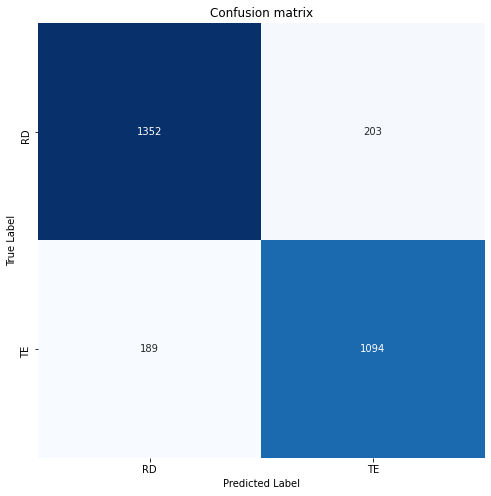

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,8))
plt.title("Confusion matrix")

categorias = ['RD','TE']
sns.heatmap(confusion_matrix(y_test, previsoes_rf),
            annot=True,
            fmt='d',
            cmap="Blues",
            cbar=False,
            xticklabels=categorias,
            yticklabels=categorias)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [ ]:
rf.feature_importances_

array([0.01560971, 0.00484725, 0.00645657, ..., 0.        , 0.        ,
       0.        ])

Validation

In [ ]:
user_frame = fasta_frame('/content/drive/My Drive/fastas/human_genes.fasta','?')
pad_frame = fasta_frame('/content/drive/My Drive/fastas/pad_ref3.fasta','?')
u_f = [user_frame,pad_frame]
user_df = pd.concat(u_f,ignore_index=True)
# print(user_df,'\n')
# OHE & flat sequences 
user_df_ohe = ohe_fun(user_df)
user_df_flat=flatten_sequence(user_df_ohe)
# print(user_df_flat,'\n')
# Remove pad_ref
user_seq_to_pred = np.delete(user_df_flat, -1, 0)
# print(user_seq_to_pred)

rf_results=rf.predict(user_seq_to_pred)
# print(rf_results)

n_rows=len(user_df.index)
pd.set_option('display.max_rows', n_rows)
resultados=pd.Series(rf.predict(user_seq_to_pred))
user_results=user_df[['ID','label']].drop(user_df.index[-1])
user_results['label']=resultados
user_results['TE_probability']=pd.Series(rf.predict_proba(user_seq_to_pred)[:,1]*100)
user_results

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.0s finished


,ID,label,TE_probability
0,ENST00000253692.11,TE,65.302453
1,ENST00000429383.8,TE,65.302453
2,ENST00000446818.6,TE,60.572125
3,ENST00000429924.6,RD,44.483299
4,ENST00000415814.6,RD,18.013301
5,ENST00000452492.6,RD,9.350476
6,ENST00000412981.5,RD,9.350476
7,ENST00000428355.5,RD,17.963301
8,ENST00000425944.5,RD,17.963301
9,ENST00000430169.5,RD,9.350476


In [ ]:
user_results.to_csv('rf_results.out.csv',index=False)

# Deep Neural Networs

In [ ]:
from sklearn import preprocessing
from numpy import array
from numpy import argmax
from keras.utils import to_categorical

lbenc = preprocessing.LabelBinarizer()
ynn = lbenc.fit_transform(y_str)

encoded = to_categorical(ynn)

In [ ]:
labtok = Tokenizer()
labtok.fit_on_texts(y_str)
print(labtok.word_counts)
print(labtok.document_count)
print(labtok.word_index)
print(labtok.word_docs)
vocab_size = len(labtok.word_index) + 1
print(vocab_size)
toklabs = labtok.texts_to_sequences(y_str)
print(toklabs)

OrderedDict([('dna', 2578), ('ltr', 4049), ('line', 577), ('sine', 41), ('rc', 263), ('retroposon', 30)])
7538
{'ltr': 1, 'dna': 2, 'line': 3, 'rc': 4, 'sine': 5, 'retroposon': 6}
defaultdict(<class 'int'>, {'dna': 2578, 'ltr': 4049, 'line': 577, 'sine': 41, 'rc': 263, 'retroposon': 30})
7
[[2], [1], [1], [1], [1], [2], [3], [1], [5], [2], [2], [2], [2], [2], [2], [2], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]

In [ ]:
from sklearn import preprocessing
from numpy import array
from numpy import argmax
from keras.utils import to_categorical

lbenc = preprocessing.LabelBinarizer()
toklabs = to_categorical(toklabs)
toklabs

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split


x_train, x_test, ynn_train, ynn_test = train_test_split(padded_seqs,
                                                        toklabs,
                                                        test_size = 0.20,
                                                        random_state = SEED,stratify=toklabs)

## CNN

### Talos model

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

np.random.seed(13)

model_teste = Sequential()
model_teste.add(Conv1D(filters=64, kernel_size=8, 
                 input_shape=(x_train.shape[1], 1)))
model_teste.add(MaxPooling1D(pool_size=4))

model_teste.add(Conv1D(filters=32, kernel_size=8))
model_teste.add(MaxPooling1D(pool_size=4))

model_teste.add(Conv1D(filters=16, kernel_size=8))
model_teste.add(MaxPooling1D(pool_size=4))

model_teste.add(Flatten())

model_teste.add(Dense(16, activation='relu'))
model_teste.add(Dense(2, activation='sigmoid'))

model_teste.compile(loss='logcosh', optimizer='adam', 
              metrics=['accuracy'])
model_teste.summary()

# Checkpoint
filepath = "model_teste_tl.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

# Fit the model
history_teste = model_teste.fit(x_train_3d, ynn_train,
                          epochs = 11,
                          batch_size = 50,
                          verbose = 1,
                          callbacks = callbacks_list,
                          validation_split = 0.0,
                          validation_data = (x_test_3d,ynn_test))

**Load model**

In [ ]:
from tensorflow.keras.models import load_model

# load model
model_teste_ld = load_model('model_teste_tl.hdf5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


**Model summary**


In [ ]:
print(model_teste_ld.summary())
# print(model_tl_ld.metrics_names)

**Evaluate**

In [ ]:
model_teste_ld.evaluate(x_test_3d, ynn_test, verbose = 1) 

2838/2838 [==============================] - 37s 13ms/sample - loss: 0.0219 - acc: 0.9387


[0.02194060454600562, 0.93868923]

**Predict using saved model**

In [ ]:
pred = model_teste_ld.predict(x_test_3d) 
pred = np.argmax(pred, axis = 1)
lab = np.argmax(ynn_test,axis = 1)

print(pred) 
print(lab)

[1 0 0 ... 0 1 1]
[1 0 0 ... 0 1 1]


### Modelo 05

#### 7 epochs

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

np.random.seed(13)

model_05 = Sequential()
model_05.add(Conv1D(filters=16, kernel_size=12, 
                 input_shape=(x_train.shape[1], 1)))
model_05.add(MaxPooling1D(pool_size=4))

model_05.add(Conv1D(filters=32, kernel_size=12))
model_05.add(MaxPooling1D(pool_size=4))

model_05.add(Conv1D(filters=16, kernel_size=12))
model_05.add(MaxPooling1D(pool_size=4))

model_05.add(Flatten())

model_05.add(Dense(16, activation='relu'))
model_05.add(Dense(2, activation='sigmoid'))

model_05.compile(loss='logcosh', optimizer='adam', 
              metrics=['accuracy'])
model_05.summary()

# Checkpoint
filepath = "/content/drive/My Drive/model_05_pr4_weights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

# Fit the model
history_05 = model_05.fit(x_train_3d, ynn_train,
                          epochs = 7,
                          batch_size = 25,
                          verbose = 1,
                          callbacks = callbacks_list,
                          validation_split = 0.0,
                          validation_data = (x_test_3d,ynn_test))

# model_05.save("/content/drive/My Drive/model_05.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 75021, 16)         208       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18755, 16)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18744, 32)         6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4686, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4675, 16)          6160      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1168, 16)          0         
_________________________________________

**Load saved model**

In [ ]:
from tensorflow.keras.models import load_model

# load model
model_05_ld = load_model('/content/drive/My Drive/model_05.h5')

# summarize model.
model05.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


**Evaluate model**

In [ ]:
model_05_ld.evaluate(x_test_3d, ynn_test, verbose = 1) 

**Predict using saved model**

In [ ]:
pred = model_05_ld.predict(x_test_3d) 
pred = np.argmax(pred, axis = 1)
label = np.argmax(ynn_test,axis = 1)

print(pred) 
print(label)

[1 0 0 ... 1 1 1]
[1 0 0 ... 1 1 1]


#### 15 epochs

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

np.random.seed(13)

model_05_01 = Sequential()
model_05_01.add(Conv1D(filters=16, kernel_size=12, 
                 input_shape=(x_train.shape[1], 1)))
model_05_01.add(MaxPooling1D(pool_size=4))

model_05_01.add(Conv1D(filters=32, kernel_size=12))
model_05_01.add(MaxPooling1D(pool_size=4))

model_05_01.add(Conv1D(filters=16, kernel_size=12))
model_05_01.add(MaxPooling1D(pool_size=4))

model_05_01.add(Flatten())

model_05_01.add(Dense(16, activation='relu'))
model_05_01.add(Dense(2, activation='sigmoid'))

model_05_01.compile(loss='logcosh', optimizer='adam', 
              metrics=['accuracy'])
model_05_01.summary()

# Checkpoint
filepath = "/content/drive/My Drive/model_05_01_pr4_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

# Fit the model
history_05_01 = model_05_01.fit(x_train_3d, ynn_train,
                                epochs = 15,
                                batch_size = 25,
                                verbose = 1,
                                callbacks = callbacks_list,
                                validation_split = 0.0,
                                validation_data = (x_test_3d,ynn_test))

# model_05_01.save("/content/drive/My Drive/model_05_01.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 75021, 16)         208       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 18755, 16)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 18744, 32)         6176      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 4686, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 4675, 16)          6160      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1168, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18688)            

In [ ]:
from tensorflow.keras.models import load_model
model_05_01 = load_model("/content/drive/My Drive/model_05_01_pr4_weights.best.hdf5")

In [ ]:
model_05_01.evaluate(x_test_3d, ynn_test)

2838/2838 [==============================] - 25s 9ms/sample - loss: 0.0207 - acc: 0.9443


[0.02072131239230383, 0.944327]

In [ ]:
pred = model_05_01.predict(x_test_3d) 
pred = pd.Series(np.argmax(pred, axis = 1),name='pred')
label = pd.Series(np.argmax(ynn_test,axis = 1),name='label')

In [ ]:
pred = model_05_01.predict(x_test_3d) 
pred = np.argmax(pred, axis = 1)
lab = np.argmax(ynn_test,axis = 1)

In [ ]:
res_05_02=pd.DataFrame(dict(pred=pred, label=label))
pd.set_option('display.max_rows', len(res_05_02))
res_05_02

#### 8 epochs

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model_05_02 = Sequential()
model_05_02.add(Conv1D(filters=16, kernel_size=12, 
                 input_shape=(x_train.shape[1], 1)))
model_05_02.add(MaxPooling1D(pool_size=4))

model_05_02.add(Conv1D(filters=32, kernel_size=12))
model_05_02.add(MaxPooling1D(pool_size=4))

model_05_02.add(Conv1D(filters=16, kernel_size=12))
model_05_02.add(MaxPooling1D(pool_size=4))

model_05_02.add(Flatten())

model_05_02.add(Dense(16, activation='relu'))
model_05_02.add(Dense(2, activation='sigmoid'))

model_05_02.compile(loss='logcosh', optimizer='adam', 
              metrics=['accuracy'])
model_05_02.summary()

# Checkpoint
filepath = "/content/drive/My Drive/model_05_02_pr4_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

# Fit the model
history_05_02 = model_05_02.fit(x_train_3d,
                                ynn_train,
                                batch_size = 25,
                                epochs = 8,
                                callbacks = callbacks_list,
                                verbose = 1,
                                validation_split = 0.0,
                                validation_data = (x_test_3d,ynn_test))

model_05_02.save("/content/drive/My Drive/model_05_02.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 109637, 16)        208       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 27409, 16)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 27398, 32)         6176      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 6849, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 6838, 16)          6160      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1709, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 27344)            

#### 11 epochs


In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

np.random.seed(13)

model_05_03 = Sequential()
model_05_03.add(Conv1D(filters=16, kernel_size=12, 
                 input_shape=(x_train.shape[1], 1)))
model_05_03.add(MaxPooling1D(pool_size=4))

model_05_03.add(Conv1D(filters=32, kernel_size=12))
model_05_03.add(MaxPooling1D(pool_size=4))

model_05_03.add(Conv1D(filters=16, kernel_size=12))
model_05_03.add(MaxPooling1D(pool_size=4))

model_05_03.add(Flatten())

model_05_03.add(Dense(16, activation='relu'))
model_05_03.add(Dense(2, activation='sigmoid'))

model_05_03.compile(loss='logcosh', optimizer='adam', 
              metrics=['accuracy'])
model_05_03.summary()

# Checkpoint
filepath = "/content/drive/My Drive/model_05_03_pr4_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

# Fit the model
history_05_03 = model_05_03.fit(x_train_3d, ynn_train,
                                epochs = 11,
                                batch_size = 25,
                                callbacks = callbacks_list,
                                verbose = 1,
                                validation_split = 0.0,
                                validation_data = (x_test_3d,ynn_test))

model_05_03.save("/content/drive/My Drive/model_05_03.h5")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 109637, 16)        208       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 27409, 16)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 27398, 32)         6176      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 6849, 32)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 6838, 16)          6160      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 1709, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 27344)            

### Variations model 05

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import  SGD

# sgd = tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=True)

np.random.seed(13)

model_var01 = Sequential()
model_var01.add(Conv1D(filters=16, kernel_size=12, 
                 input_shape=(x_train.shape[1], 1),activation='relu'))
model_var01.add(MaxPooling1D(pool_size=4))

model_var01.add(Conv1D(filters=32, kernel_size=12,activation='relu'))
model_var01.add(MaxPooling1D(pool_size=4))

# model_var01.add(Conv1D(filters=16, kernel_size=12,activation='relu'))
# model_var01.add(MaxPooling1D(pool_size=4))

model_var01.add(Flatten())

model_var01.add(Dense(16, activation='relu'))
model_var01.add(Dropout(0.2))
model_var01.add(Dense(2, activation='softmax'))

model_var01.compile(loss='categorical_crossentropy', optimizer='sgd', 
              metrics=['accuracy'])
# model_var01.summary()

# Checkpoint
filepath = "/content/drive/My Drive/model_var01.wb.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

# Fit the model
history_var01 = model_var01.fit(x_train_3d, ynn_train,
                                epochs = 25,
                                batch_size = 25,
                                verbose = 1,
                                callbacks = callbacks_list,
                                validation_split = 0.0,
                                validation_data = (x_test_3d,ynn_test),
                                shuffle=True)

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import  SGD

# sgd = tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=True)

np.random.seed(13)

model_var01_01 = Sequential()
model_var01_01.add(Conv1D(filters=16, kernel_size=12, 
                 input_shape=(x_train.shape[1], 1),activation='relu'))
model_var01_01.add(MaxPooling1D(pool_size=4))

model_var01_01.add(Flatten())

model_var01_01.add(Dense(16, activation='relu'))
model_var01_01.add(Dropout(0.2))
model_var01_01.add(Dense(2, activation='softmax'))

model_var01_01.compile(loss='categorical_crossentropy', optimizer='sgd', 
              metrics=['accuracy'])
# model_var01.01.summary()

# Checkpoint
filepath = "/content/drive/My Drive/model_var01.01.wb.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

# Fit the model
history_var01_01 = model_var01_01.fit(x_train_3d, ynn_train,
                                epochs = 25,
                                batch_size = 25,
                                verbose = 1,
                                callbacks = callbacks_list,
                                validation_split = 0.0,
                                validation_data = (x_test_3d,ynn_test),
                                shuffle=True)

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential

np.random.seed(13)

model_var01_02 = Sequential()
model_var01_02.add(Conv1D(filters=64, kernel_size=12, 
                 input_shape=(x_train.shape[1], 1),activation='relu'))
model_var01_02.add(MaxPooling1D(pool_size=4))

model_var01_02.add(Conv1D(filters=24, kernel_size=12,activation='relu'))
model_var01_02.add(MaxPooling1D(pool_size=4))

model_var01_02.add(Flatten())

model_var01_02.add(Dense(24, activation='relu'))
model_var01_02.add(Dropout(0.2))
model_var01_02.add(Dense(2, activation='softmax'))

model_var01_02.compile(loss='categorical_crossentropy', optimizer='sgd', 
              metrics=['accuracy'])
# model_var01_02.summary()

# Checkpoint
filepath = "/content/drive/My Drive/model_var01.02.wb.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

# Fit the model
history_var01_02 = model_var01_02.fit(x_train_3d, ynn_train,
                                epochs = 25,
                                batch_size = 10,
                                verbose = 1,
                                callbacks = callbacks_list,
                                validation_split = 0.0,
                                validation_data = (x_test_3d,ynn_test),
                                shuffle=True)

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential

np.random.seed(13)

model_var01_03 = Sequential()
model_var01_03.add(Conv1D(filters=16, kernel_size=12, 
                 input_shape=(x_train.shape[1], 1),activation='relu'))
model_var01_03.add(MaxPooling1D(pool_size=4))

model_var01_03.add(Flatten())

model_var01_03.add(Dense(24, activation='relu'))
# model_var01_03.add(Dropout(0.2))
model_var01_03.add(Dense(2, activation='softmax'))

model_var01_03.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
# model_var01.02.summary()

# Checkpoint
filepath = "/content/drive/My Drive/model_var01.03.wb.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

# Fit the model
history_var01_03 = model_var01_03.fit(x_train_3d, ynn_train,
                                epochs = 25,
                                batch_size = 10,
                                verbose = 1,
                                callbacks = callbacks_list,
                                validation_split = 0.0,
                                validation_data = (x_test_3d,ynn_test),
                                shuffle=True)

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential

np.random.seed(13)

model_var01_04 = Sequential()
model_var01_04.add(Conv1D(filters=32, kernel_size=8, 
                 input_shape=(x_train.shape[1], 1),activation='relu'))
model_var01_04.add(MaxPooling1D(pool_size=4))

model_var01_04.add(Conv1D(filters=16, kernel_size=8,activation='relu'))
model_var01_04.add(MaxPooling1D(pool_size=4))

model_var01_04.add(Conv1D(filters=16, kernel_size=8,activation='relu'))
model_var01_04.add(MaxPooling1D(pool_size=4))

model_var01_04.add(Flatten())

model_var01_04.add(Dense(8, activation='relu'))
# model_var01.04.add(Dropout(0.2))
model_var01_04.add(Dense(2, activation='softmax'))

model_var01_04.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
# model_var01.04.summary()

# Checkpoint
filepath = "/content/drive/My Drive/model_var01.04.wb.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

# Fit the model
history_var01_04 = model_var01_04.fit(x_train_3d, ynn_train,
                                epochs = 15,
                                batch_size = 10,
                                verbose = 1,
                                callbacks = callbacks_list,
                                validation_split = 0.0,
                                validation_data = (x_test_3d,ynn_test),
                                shuffle=True)

### Selected model from variations

In [ ]:
# SELECTED MODEL

from tensorflow.keras.layers import Embedding, Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential

tf.random.set_random_seed(SEED)
np.random.seed(SEED)

nkernel=12
npool=7
emb_dim = 12

model_var01_05 = Sequential()

model_var01_05.add(Embedding(input_dim=vocab_size, 
                           output_dim=emb_dim, 
                           input_length=x_train.shape[1]))

model_var01_05.add(Conv1D(filters=24, kernel_size=nkernel,
                          input_shape=(x_train.shape[1], 1),
                          activation='relu'))
model_var01_05.add(MaxPooling1D(pool_size=npool))

model_var01_05.add(Conv1D(filters=16, kernel_size=nkernel,activation='relu'))
model_var01_05.add(MaxPooling1D(pool_size=npool))

model_var01_05.add(Conv1D(filters=16, kernel_size=nkernel,activation='relu'))
model_var01_05.add(MaxPooling1D(pool_size=npool))

model_var01_05.add(Conv1D(filters=16, kernel_size=nkernel,activation='relu'))
model_var01_05.add(MaxPooling1D(pool_size=npool))

model_var01_05.add(Flatten())

model_var01_05.add(Dense(24, activation='relu'))
model_var01_05.add(Dropout(0.4))
model_var01_05.add(Dense(7, activation='softmax'))

model_var01_05.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model_var01_05.summary()

# Checkpoint
filepath = "/content/drive/My Drive/model_nadd_embedded_wb.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

# Fit the model
history_var01_05 = model_var01_05.fit(x_train, ynn_train,
                                epochs = 20,
                                batch_size = 10,
                                verbose = 1,
                                callbacks = callbacks_list,
                                validation_split = 0.0,
                                validation_data = (x_test,ynn_test),
                                shuffle = True)

model_var01_05.save("/content/drive/My Drive/model_nadd_embedded.hdf5")

# Save history binary
with open("/content/drive/My Drive/model_nadd_embedded_saved_history.pkl","wb") as file_pi:
  pickle.dump(history_var01_05.history, file_pi)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 27418, 12)         84        
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 27407, 24)         3480      
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 3915, 24)          0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 3904, 16)          4624      
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 557, 16)           0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 546, 16)           3088      
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 78, 16)          

In [ ]:
rev_word_map = dict(map(reversed, labtok.word_index.items()))
rev_word_map

{1: 'ltr', 2: 'dna', 3: 'line', 4: 'rc', 5: 'sine', 6: 'retroposon'}

In [ ]:
predicted = model_var01_05.predict_classes(x_test[-500:])
# predicted

In [ ]:
# for item in ynn_test[5:15]:
#   print(argmax(item))
true_labs = np.array([argmax(item) for item in ynn_test[-500:]])
# true_labs

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print(accuracy_score(true_labs, predicted))
print(f1_score(true_labs, predicted, average = 'weighted'))

0.918
0.9115345161746735


In [ ]:
# SELECTED MODEL var
# Changing kernel, padding

from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential

tf.compat.v1.random.set_random_seed(SEED)
np.random.seed(SEED)
for i in range(0,11):
  i=i+1
  print("-----------------")
  print(f"Starting round {i}.")
  print("-----------------")
  model_var01_05 = Sequential()
  model_var01_05.add(Conv1D(filters=24, kernel_size=12, 
                  input_shape=(x_train.shape[1], 1),activation='relu'))
  model_var01_05.add(MaxPooling1D(pool_size=7))

  model_var01_05.add(Conv1D(filters=16, kernel_size=12,activation='relu'))
  model_var01_05.add(MaxPooling1D(pool_size=7))

  model_var01_05.add(Conv1D(filters=16, kernel_size=12,activation='relu'))
  model_var01_05.add(MaxPooling1D(pool_size=7))

  model_var01_05.add(Conv1D(filters=16, kernel_size=12,activation='relu'))
  model_var01_05.add(MaxPooling1D(pool_size=7))

  model_var01_05.add(Flatten())

  model_var01_05.add(Dense(24, activation='relu'))
  # model_var01_05.add(Dropout(0.2))
  model_var01_05.add(Dense(2, activation='softmax'))

  model_var01_05.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=['accuracy'])
  # model_var01_05.summary()

  # Checkpoint
  filepath = f"model_nadd_241624152502_{i}_wb.hdf5"
  checkpoint = ModelCheckpoint(filepath,
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,
                              mode='min')
  callbacks_list = [checkpoint]

  # Fit the model
  history_var01_05 = model_var01_05.fit(x_train_3d, ynn_train,
                                  epochs = 15,
                                  batch_size = 25,
                                  verbose = 1,
                                  callbacks = callbacks_list,
                                  validation_split = 0.0,
                                  validation_data = (x_test_3d,ynn_test),
                                  shuffle = True)
  # Save final model
  model_var01_05.save(f"model_nadd_241624152502_{i}.hdf5")
  # Save history binary
  with open(f"model_nadd_241624152502_{i}_saved_history","wb") as file_pi:
    pickle.dump(history_var01_05.history, file_pi)
  print("-----------------")
  print(f"Round {i} finished!")
  print("-----------------")


-----------------
Starting round 1.
-----------------
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 12535 samples, validate on 3134 samples
Epoch 1/15
12500/12535 [============================>.] - ETA: 0s - loss: 0.5217 - acc: 0.7144
Epoch 00001: val_loss improved from inf to 0.50012, saving model to model_nadd_241624152502_1_wb.hdf5
12535/12535 [==============================] - 32s 3ms/sample - loss: 0.5218 - acc: 0.7144 - val_loss: 0.5001 - val_acc: 0.7355
Epoch 2/15
12525/12535 [============================>.] - ETA: 0s - loss: 0.4873 - acc: 0.7432
Epoch 00002: val_loss improved from 0.50012 to 0.48494, saving model to model_nadd_241624152502_1_wb.hdf5
12535/12535 [==============================] - 25s 2ms/sample - loss: 0.4872 - acc: 0.7432 - val_loss: 0.4849 - val_acc: 0.7709
Epoch 3/15
12525/12535 [============================>.] - ETA: 0s - loss: 0.4300 - acc: 0.7909
Epoch 00003: val_loss improved from 0.48494 to 0.46750, saving mode

In [ ]:
model_var01_05.save("/content/drive/My Drive/model_nadd_var01.05.hdf5")

In [ ]:
# Save history binary
with open("model_nadd_var01_05_saved_history","wb") as file_pi:
  pickle.dump(history_var01_05.history, file_pi)

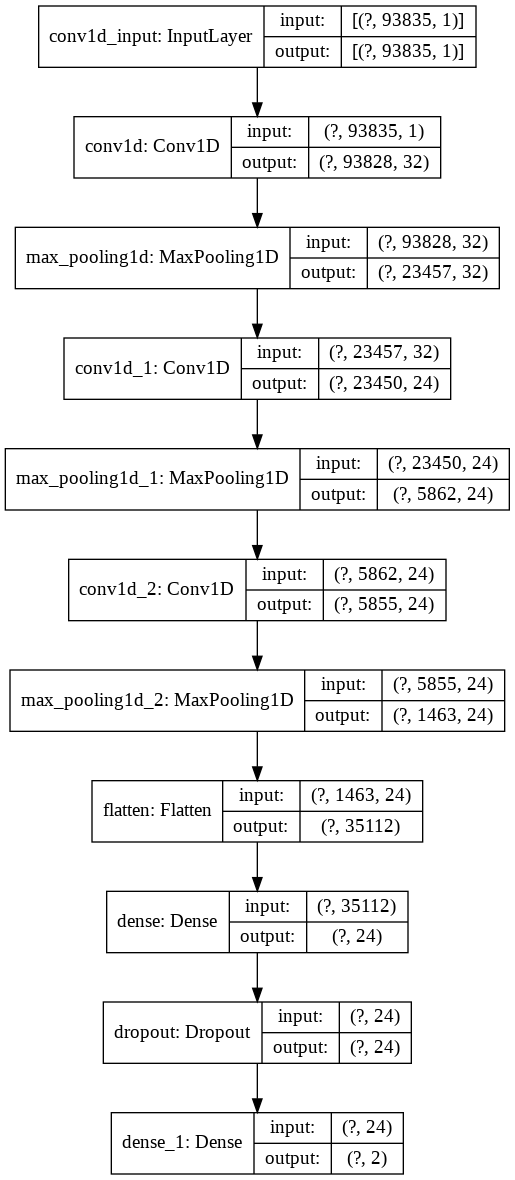

In [ ]:
# Plot model
tf.keras.utils.plot_model(model_var01_05,
                          show_shapes = True,
                          show_layer_names = True,
                          to_file = 'model_nadd_var01_05.png')

In [ ]:
# load model
mdl_ld = load_model('model_var01.05_N.wb.hdf5')

## LSTM

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM
from keras.models import Sequential
from keras import backend
# backend.clear_session()

tf.compat.v1.random.set_random_seed(SEED)
np.random.seed(SEED)

model_LSTM = Sequential()
model_LSTM.add(Conv1D(filters=32, kernel_size=8, 
                 input_shape=(x_train.shape[1], 1),activation='relu'))
model_LSTM.add(MaxPooling1D(pool_size=2))

model_LSTM.add(Conv1D(filters=24, kernel_size=8,activation='relu'))
model_LSTM.add(MaxPooling1D(pool_size=2))

model_LSTM.add(LSTM(units = 24,
                    return_sequences = True))

model_LSTM.add(Flatten())
model_LSTM.add(Dense(16,activation='relu'))
model_LSTM.add(Dense(2,activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

model_LSTM.summary()

history_LSTM = model_LSTM.fit(x_train_3d, ynn_train,
                              epochs = 15,
                              batch_size = 25,
                              verbose = 1,
                              validation_split = 0.0,
                              validation_data = (x_test_3d,ynn_test),
                              shuffle = True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 93828, 32)         288       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 46914, 32)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 46907, 24)         6168      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 23453, 24)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 23453, 24)         4704      
_________________________________________________________________
flatten_3 (Flatten)          (None, 562872)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)               

KeyboardInterrupt: ignored

In [ ]:
history_LSTM = model_LSTM.fit(x_train_3d, ynn_train,
                              epochs = 25,
                              batch_size = 10,
                              verbose = 1,
                              validation_split = 0.0,
                              validation_data = (x_test_3d,ynn_test),
                              shuffle = True)

## Plot results

In [ ]:
def perc_val(data):
  dtl = []
  for dt in data:
    dtl.append(dt*100)
  return(dtl)

lv_list = history_var01_05.history['loss']
vlv_list = history_var01_05.history['val_loss']
av_list = perc_val(history_var01_05.history['acc'])
vav_list = perc_val(history_var01_05.history['val_acc'])

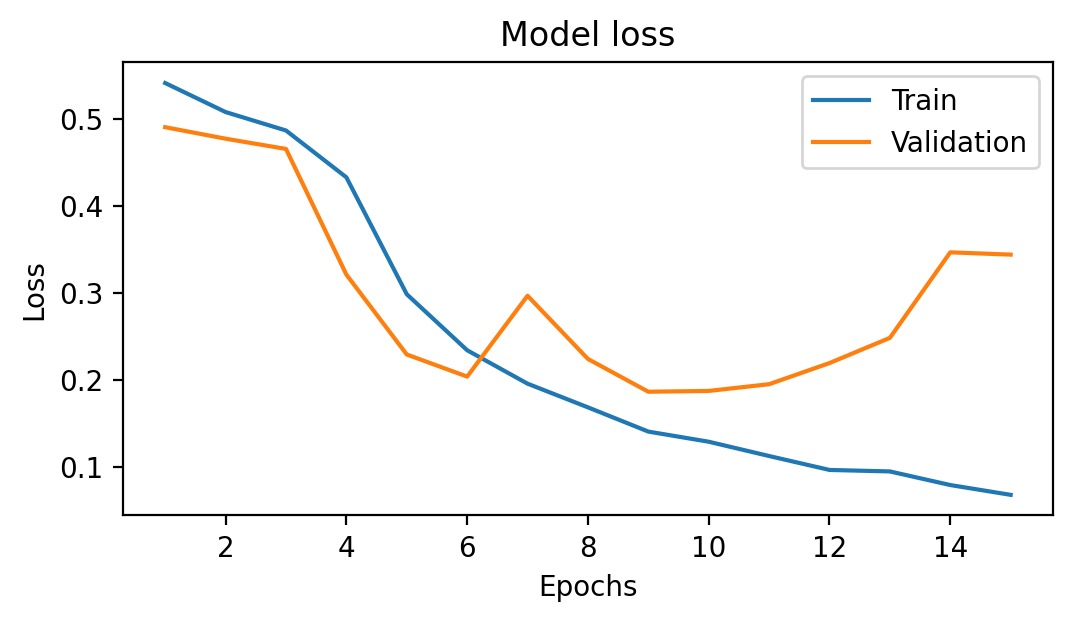

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(6,3), dpi=200)
epoch_count = range(1, len(history_var01_05.history['val_loss']) + 1)
plt.plot(epoch_count, lv_list)
plt.plot(epoch_count, vlv_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

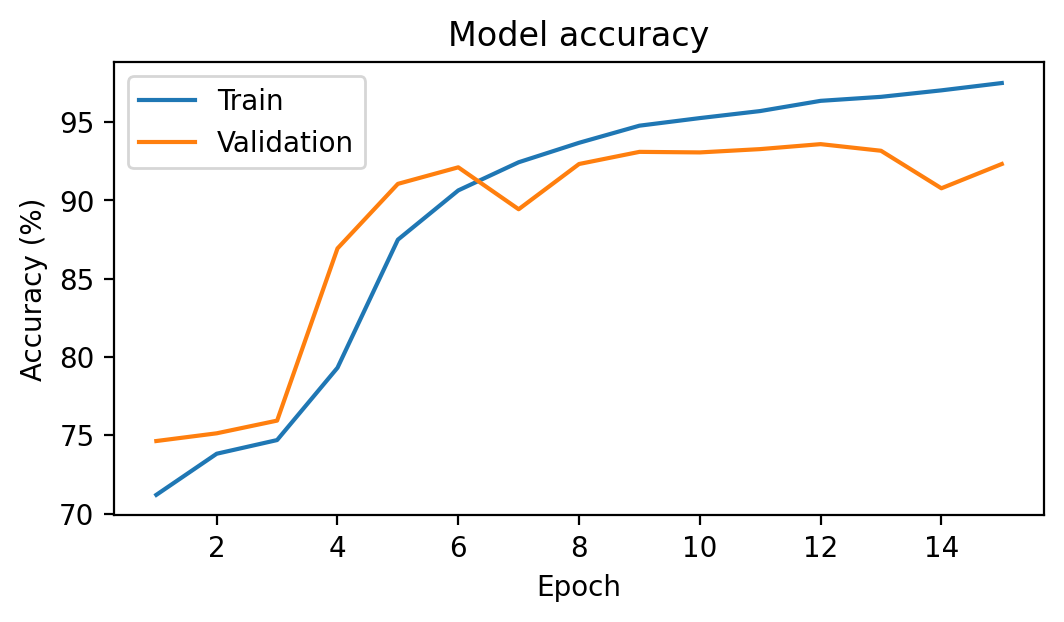

In [ ]:
plt.figure(figsize=(6,3), dpi=200)
epoch_count = range(1, len(history_var01_05.history['val_acc']) + 1)
plt.plot(epoch_count, av_list)
plt.plot(epoch_count, vav_list)
plt.title('Model accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
mdl_ld = load_model("/content/drive/My Drive/model_var01.05.wb.hdf5")

In [ ]:
pred = mdl_ld.predict(x_test_3d)
pred = np.argmax(pred, axis = 1)
lab = np.argmax(ynn_test,axis = 1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(lab,pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1555
           1       0.92      0.94      0.93      1283

    accuracy                           0.94      2838
   macro avg       0.93      0.94      0.93      2838
weighted avg       0.94      0.94      0.94      2838



Text(0.5, 51.0, 'Predicted Label')

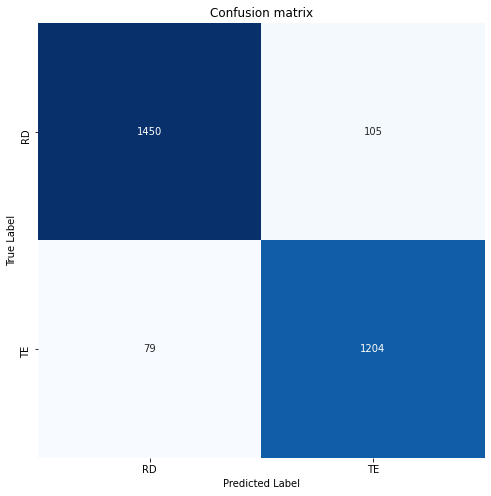

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

plt.figure(figsize=(8,8))
plt.title("Confusion matrix")

categorias = ['RD','TE']
sns.heatmap(confusion_matrix(lab,pred),
            annot=True,
            fmt='d',
            cmap="Blues",
            cbar=False,
            xticklabels=categorias,
            yticklabels=categorias)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

Confusion matrix:
 [[1504   50]
 [  87 1078]]


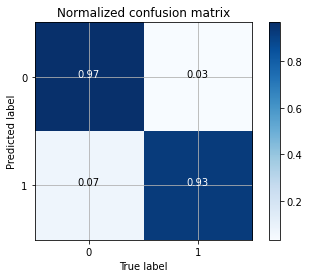

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(np.argmax(ynn_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

## Validation tests with external data

TEs validation

In [ ]:
user_frame = fasta_frame('/content/drive/My Drive/fastas/tes_validation.fasta','?')
pad_frame = fasta_frame('/content/drive/My Drive/fastas/pad_ref3.fasta','?')
u_f = [user_frame,pad_frame]
user_df = pd.concat(u_f,ignore_index=True)

# OHE & flat sequences 
user_df_ohe = ohe_fun(user_df)
user_df_flat=flatten_sequence(user_df_ohe)

# Remove pad_ref
user_seq_to_pred = np.delete(user_df_flat, -1, 0)

In [ ]:
predicted_labels_val_05_01 = mdl_ld.predict(np.expand_dims(user_seq_to_pred, axis=2))
print("Modelo 05_01")
print(predicted_labels_val_05_01.argmax(axis=-1))

Modelo 05_01
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]


Human genes

In [ ]:
user_frame_hg = fasta_frame('/content/drive/My Drive/fastas/human_genes.fasta','?')
pad_frame = fasta_frame('/content/drive/My Drive/fastas/pad_ref3.fasta','?')
u_f_hg = [user_frame_hg,pad_frame]
user_df_hg = pd.concat(u_f_hg,ignore_index=True)

# OHE & flat sequences 
user_df_ohe_hg = ohe_fun(user_df_hg)
user_df_flat_hg=flatten_sequence(user_df_ohe_hg)

# Remove pad_ref
user_seq_to_pred_hg = np.delete(user_df_flat_hg, -1, 0)

In [ ]:
predicted_labels_hg_05_01 = mdl_ld.predict(np.expand_dims(user_seq_to_pred_hg, axis=2))
print("Modelo 05_01")
print(predicted_labels_hg_05_01.argmax(axis=-1))

Modelo 05_01
[0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
